In [ ]:
# sentencepiece was the issue install 0.1.86
# if error occurs during training that gives a segmantion error it is most likely the sentencpice version

In [ ]:
import pickle
from collections import Counter

import ktrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from joblib import dump
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, \
    confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from utils.data import process_transcripts
from utils.model import get_performance, train_learner, set_seeds, predict_test

plt.rcdefaults()
import seaborn as sns
import sklearn
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from ktrain import text

config = tf.compat.v1.ConfigProto(gpu_options=
                                  tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
                                  # device_count = {'GPU': 1}
                                  )
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [5]:
# this shows available GPU's. If you have a NVIDIA GPU but dont see it here there is a vesioning erorr
# or cuda is missing!
# check here for more infos about compatibility between tensorflow 2, cuDNN, and cuda
# https://www.tensorflow.org/install/source#gpu
tf.config.list_physical_devices('GPU')


[]

In [6]:
variable_code = "MF02_01"
df_var = process_transcripts(variable_code)

Number of samples from joined texts and Excel  by ID: (2936, 158)
Number of samples with only coder -9: (2518, 4)
Frequencies of labels: [(2, 1420), (1, 1098)]


Mean length of texts: 314.6544876886418
 95th percentile of text lengths: 924.3000000000002
99th percentile of text lengths: 1409.1299999999992


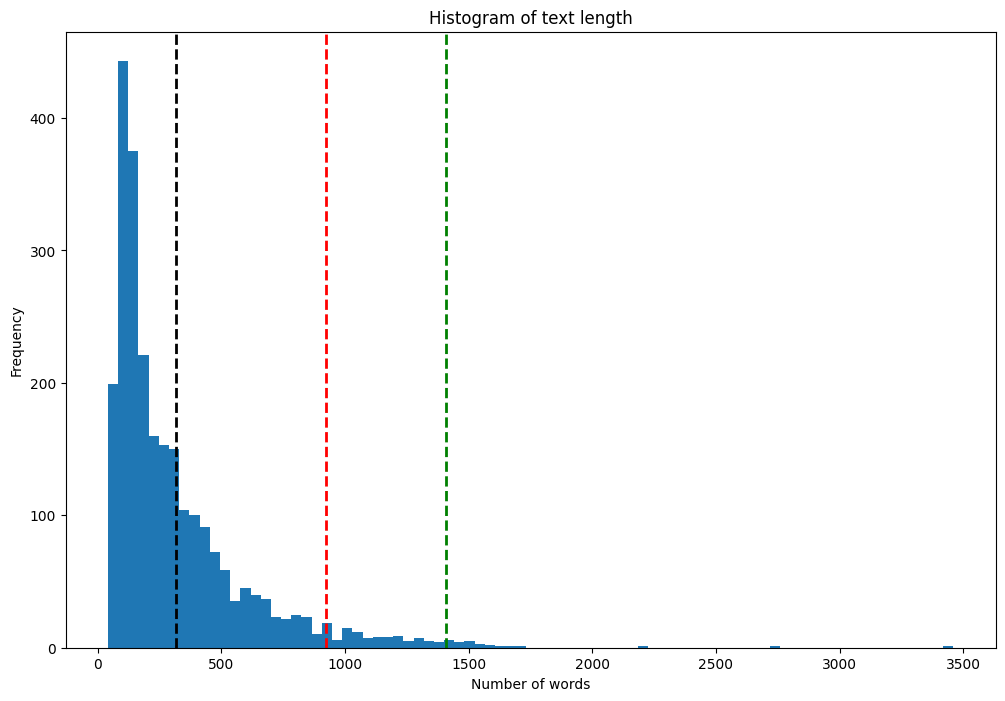

In [7]:
# sequence length histogram to determine cutoff
lengths = [len(text.split(" ")) for text in df_var.text.values]

fig, ax = plt.subplots(figsize=(12, 8))

plt.hist(lengths, bins='auto')
plt.axvline(np.mean(lengths), color='k', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(lengths, 99), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title("Histogram of text length")
fig.savefig("seq_len_CI.png", dpi=600)
print(f"Mean length of texts: {np.mean(lengths)}\n "
      f"95th percentile of text lengths: {np.percentile(lengths, 95)}\n"
      f"99th percentile of text lengths: {np.percentile(lengths, 99)}")

In [8]:
df_var.shape

(2518, 4)

In [9]:
# add here the latest Excel with the manually coded variable codes
f = "./data/new/V!brant_data_all_161220.xlsx"
df_classes = pd.read_excel(f)

In [10]:
df_classes = df_classes.iloc[1:]

In [11]:
word_len = [len(text.split(" ")) for text in df_var.text.values]
longer = 0
for len_ in word_len:
    if len_ > 512:
        longer += 1
print(longer, longer / df_var.shape[0])


422 0.1675933280381255


In [12]:
# train val and test split
# stratify=df["class"] ensures that the subsets contain a similar distributions as original data
X_train, X_test, y_train, y_test = train_test_split(df_var.text
                                                    , df_var[variable_code], test_size=0.2,
                                                    random_state=1, stratify=df_var[variable_code])

X_train, X_val, y_train, y_val = train_test_split(X_train
                                                  , y_train, test_size=0.2, random_state=1,
                                                  stratify=y_train)

# Custom functions for training and testing

In [13]:
# the model name can be any transformers model (see https://huggingface.co/transformers/pretrained_models.html)
model_name = "bert-base-uncased"
#modelName = "xlnet-base-cased"
# set default parameters for deep learning
lr = 5e-5
epoch = 3
seed = 1
maxlen = 512  # max 512 for BERT based models, for twitter we use visual anaylsis to reduces to ~100
# the smaller the lenght the quicker the training
class_names = y_train.unique()
t = text.Transformer(model_name,
                     maxlen=maxlen,
                     class_names=class_names)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# running grid search training TFIDF and SVM
def run_SVM_CV(train_features, test_features, y_train, y_test, confusion=True, verbose=True):
    metrics = np.zeros(4)

    # if u want to add SMOTE, just uncomment it in the pipline and paramters!
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),  #CountVectorizer
        #  ("smote", SMOTE(random_state=1, n_jobs=-1)), #uncomment me if SMOTE
        ('clf', SVC(random_state=1)),
    ])

    # here we can play around with the parameters
    # for SVM params check https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # for tfidf params check https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

    parameters = {
        #  'vect__max_df': (0.5, 0.75, 1.0),
        #  "vect__stop_words":[None, "english"],
        'vect__max_features': (None, 10000, 25000, 50000),
        'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        #    "smote__k_neighbors" : [5], # uncommnet me if SMOTE
        'clf__C': np.arange(0.01, 1.01, 0.15),
        'clf__kernel': ["rbf", "linear"],
        'clf__class_weight': ["balanced"],
        "clf__decision_function_shape": ["ovo", "ovr"], }
    scorer = sklearn.metrics.make_scorer(f1_score, average='macro')
    # cv=5 is a 5-fold cross validation
    gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5, scoring=scorer)
    # runs gridsearch with pipeline and parameters
    gs_clf.fit(train_features, y_train)
    print(f"Best parameters found during grid search: \n{gs_clf.best_params_}")
    test_pred = gs_clf.predict(test_features)
    metrics += [f1_score(y_test, test_pred, average="macro"),
                precision_score(y_test, test_pred, average="macro"),
                recall_score(y_test, test_pred, average="macro"),
                accuracy_score(y_test, test_pred)
                ]
    if verbose:
        print(
            'F1: {:.3f} | Precision: {:.3f} | Recall: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics)
        )
    if confusion:
        print(confusion_matrix(y_test, test_pred))
    return gs_clf

In [ ]:
model = run_SVM_CV(X_train, X_val, y_train, y_val)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


/Users/hubertbaginski/Desktop/venv/bin/TranscriptsSuicideML/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
pred = model.predict(X_test)
mat = get_performance(y_test.values, pred, class_names)
print(classification_report(y_test, pred))

In [ ]:
Counter(y_test)
dump(model, variable_code + '.joblib')

In [ ]:
labels = y_test.values
index = columns = class_names
cm_df = pd.DataFrame(mat / np.sum(mat), columns, index)
plt.figure(figsize=(10, 8.2))
sns.heatmap(cm_df, annot=True, fmt=".0%"
            )
plt.yticks(rotation=0, fontsize=12)

## Saving and loading sklearn models

for more information check out this article: 
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
mat = get_performance(y_test.values, result, class_names)

# Training the BERT base model with original data.

In [ ]:
original_learner = train_learner(
    X_train, y_train.values,
    X_val, y_val.values,
    lr=1.5e-5, epoch=8, seed=1, text_length=512, model_name=model_name,
    checkpoint_folder="D:/models/transcript_models/"
    # add the path where the checkpoints should be saved
)

## After the training has finished, you will see the training statistics. I usually choose the epoch with the highest validation accuracy (if two performances were similar I chose the one with the lower validation loss).

If you used a checkpoint folder, you can load the model with the best performance rather than the last epoch. E.g. if you trained for 5 epochs, the default behaviour is that the model will use the last run, i.e. epoch 5. But if the performance of epoch 5 is worse than epoch 3, you can manually load the weights of epoch 3. See below:

In [ ]:
original_learner[4].load_weights("D:/models/transcript_models/weights-06.hdf5")

learner_reloaded = ktrain.get_learner(original_learner[4], train_data=original_learner[2],
                                      val_data=original_learner[3], batch_size=2)

model_ = learner_reloaded
t_ = original_learner[1]
trn_ = original_learner[2]

# setting seeds (redundantly) before predicting validation set
set_seeds(seed)
# usually you only have to do this if you are interested in inter-class statistics of the
# validation set:D
## PREDICT ON VALIDATION SET
pred = predict_test(X_val.values, model_, t=t_)
predictor = pred[1]
val = t_.preprocess_test(X_val.values, y_val.values)
model_.validate(val_data=val)
mat = get_performance(y_val.values, pred[0], class_names)

## PREDICT ON TEST SET
set_seeds(seed)
pred = predict_test(X_test.values, model_, t=t_)
predictor = pred[1]
test = t_.preprocess_test(X_test.values, y_test.values)
model_.validate(val_data=test, class_names=list(class_names))
mat = get_performance(y_test.values, pred[0], class_names)

## Saving a ktrain model
If the test performance was good, and you want to save the actual model (not only the weights of the training) call **predictor.save( "yourPath")**.

In [ ]:
# saving the ktrain model to disk ~500MB 
predictor.save("D:/models/models/" + variable_code)

In [ ]:
labels = y_test.values
index = columns = class_names
cm_df = pd.DataFrame(mat / np.sum(mat), columns, index)
plt.figure(figsize=(10, 8.2))
sns.heatmap(cm_df, annot=True, fmt=".0%"
            )
plt.yticks(rotation=0, fontsize=12)
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title(f"Confusion matrix test set, n={len(X_test)}", fontsize=25)

In [ ]:
# saving the predictor
predictor.save("/home/lv71526/hbaginski/models/" + variable_code)


In [ ]:
# loading predictor 
# loading model
reloaded_model = ktrain.load_predictor("/home/lv71526/hbaginski/models/" + variable_code)
new_pred = get_performance(y_test.values, reloaded_model.predict(X_test), class_names)